In [ ]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode (connected = True)


from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")  
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

#  My other notebooks :
* [Basic EDA with visualization  and animated polar plot](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-data-exploration-animation) 
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [Features selection](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-the-less-the-better)
* [MultiOutput regressor, 65 targets in one](https://www.kaggle.com/code/martynovandrey/tps-mar-22-multioutput-regressor)
* [Hybrid regressor, two step model](https://www.kaggle.com/code/martynovandrey/tps-mar-22-hybrid-regressors)
* [Multimodel regression, blendig, postprocessing - my best public score so far](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

## Continued from [TPS Mar 22, Step 0 - Data Exploration, animation](https://www.kaggle.com/martynovandrey/tps-mar-22-step-0-data-exploration-animation)

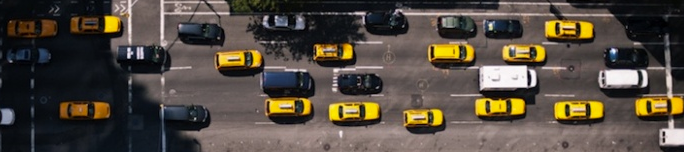

Thanks to [AMBROSM](https://www.kaggle.com/ambrosm) for recomendation to pay attention for special values of congestion in his great [notebook](https://www.kaggle.com/ambrosm/tpsmar22-eda-which-makes-sense)

In this small notebook I try to get a closer look and make a tool for finding patterns.

* **Update**: manual correction my best submission at the moment with values from the next 5 plots improves public score from **4.976** to **4.929**. Not bad!

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])
k = train.shape[0] / test.shape[0]

### Directions

In [ ]:
directions = train['direction'].unique().tolist()
degree = {'EB':180, 'NB':90, 'SB':270, 'WB':0, 'NE':135, 'SW':315, 'NW': 45, 'SE':225}

dirs = pd.DataFrame(train['direction'].value_counts())
dirs['degree'] = list(degree.values())
dirs = dirs.rename(columns={'direction':'train'})
dirs['test'] = test['direction'].value_counts()
dirs = dirs.sort_values(by='degree')
dirs['rad'] = math.pi * dirs['degree'] / 180
dirs = dirs[['degree', 'rad', 'train', 'test']]

In [ ]:
tmp = dirs[['degree', 'rad']].reset_index().rename(columns={'index':'direction'})
train = pd.merge(train, tmp, on='direction', how='left')
test = pd.merge(test, tmp, on='direction', how='left')

### Combine "x" and "y" into "road"

In [ ]:
train['road'] = train['x'].astype(str) + train['y'].astype(str)
test['road']  = test['x'].astype(str) + test['y'].astype(str)

locs = pd.DataFrame()
locs['train'] = train['road'].value_counts()
locs['test'] = test['road'].value_counts()
locs['test_k'] = (test['road'].value_counts() * k).astype(int)

roads = locs.index.tolist() #.sort()
roads.sort()

# Congestion special values

In [ ]:
# FROM AMBROSM'S NOTEBOOK
plt.figure(figsize=(10, 6))
plt.bar(range(101), train.congestion.value_counts().sort_index(), width=1,
        color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in range(101)])
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.show()

In [ ]:
special = [15, 20, 21, 29, 34]

### roads  of special values

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(special), figsize=(20, 3))
for ax, value in zip(axs.flat, special):                        
    sample = train[train['congestion'] == value]
    loc_counts = pd.DataFrame(sample['road'].value_counts())
    sns.barplot(x=loc_counts.index, y=loc_counts.road, ax=ax)
    ax.set_title(f'value {value}')

### Each value has it's "favorite" road

In [ ]:
value_anomalies = [(15,'21'), (20,'22'), (21,'22'), (29,'21'), (34,'21')]

### Distribution of special values by direction for each road

In [ ]:
df = pd.DataFrame(degree.values(), index=list(degree.keys())).rename(columns={0:'degree'}).sort_values(by='degree')
df['rad'] = math.pi * df['degree'] / 180

fig, axs = plt.subplots(nrows=1, ncols=len(special), figsize=(24, 4)) #, subplot_kw=dict(projection='polar'))
for ax, anomaly in zip(axs.flat, value_anomalies):                        
    sample = train[train['congestion'] == anomaly[0]]
    sample = sample[sample['road'] == anomaly[1]]
    dir_counts = pd.DataFrame(sample['direction'].value_counts())
    sns.barplot(x=dir_counts.index, y=dir_counts.direction, ax=ax)
    ax.set_title(f'value {anomaly[0]}, loc {anomaly[1]}')

### For each one direction has near 100%

In [ ]:
road_anomalies = [('21', 'NE', 15), ('22', 'SE', 20), ('22', 'NW', 21), ('21', 'NW', 29), ('21', 'SE', 34)]

## Time
### Add datetime features 

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 
    
add_datetime_features(train)
add_datetime_features(test)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train['num'] = le.fit_transform(train['time'])

In [ ]:
train

In [ ]:
test

# Time series
### Let's have a closer look with zoomable time series plots

In [ ]:
import plotly.express as px

for a in road_anomalies:
    sample = train[(train.road == a[0]) & (train.direction == a[1])]
    sample['special'] = sample.congestion == a[2]
    fig = px.scatter(sample, x='time', y='congestion', color='special', title=f'road {a[0]}, direction {a[1]}')
    fig.show()

* If zoom the first plot, we see some pattern  
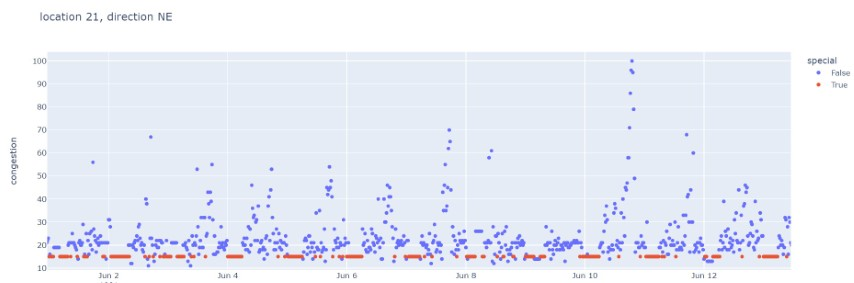  
* Zoom more and it looks like special value (15) is there about from 00:00 to 06:00  
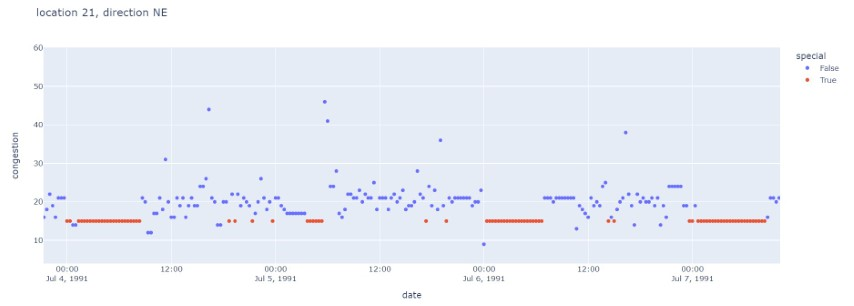  
* Interesting, but I can't imagine the reason  
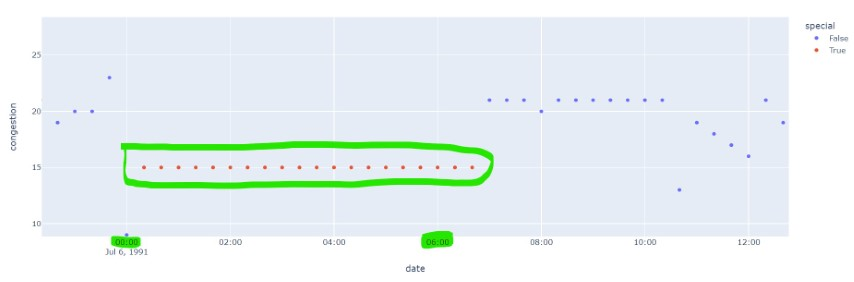  


* The last plot, the same road "21", direction "SE", special 34 is almost the only value but rare outliers  
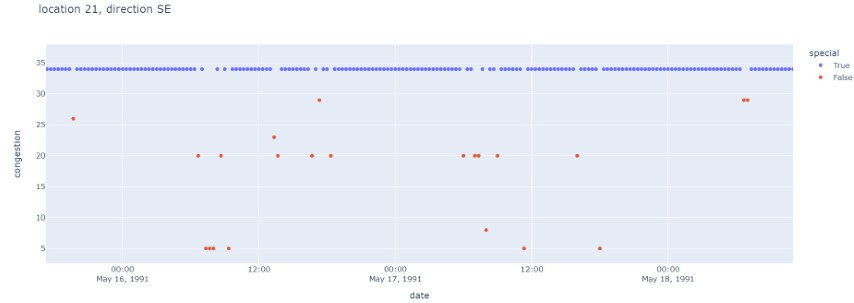  
* Direction "NW", the same road, has weekly cycle of outliers:  
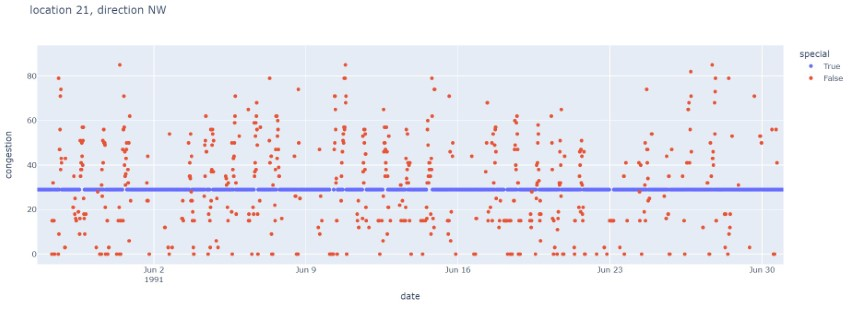  
* Zoom into one week, every day, but Sunday, someting happens in the afternoon    
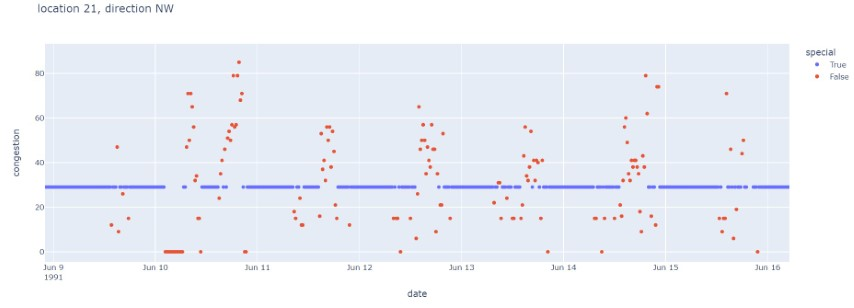  

* The similar weekly cycle on road "22" "NW"

# If there are another anomalies, may be for single time point?

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])

train['road'] = train['x'].astype(str) + train['y'].astype(str) + train['direction']
test['road']  = test['x'].astype(str) + test['y'].astype(str) + test['direction']

train = train.drop(['x', 'y', 'direction'], axis=1)
test = test.drop(['x', 'y', 'direction'], axis=1)

def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20
add_datetime_features(train)
add_datetime_features(test)

In [ ]:
roads = list(train.road.unique())
df = train[train.time.dt.weekday == 0]
df = df[df.time.dt.hour >= 12]
hours = list(df.time.dt.hour.unique())
moments = list(df.moment.unique())
anomalies = []
for road in roads:
    if not road in ['21NE', '22SE', '22NW', '21NW', '21SE']:
        for moment in moments:
            sample = df[(df.road == road) & (df.moment == moment)]
            hour = moment // 3
            minute = (moment % 3) * 20
            vc = sample.congestion.value_counts()
            counts = list(vc)
            if len(counts) > 0:
                if counts[0] > 0.3 * sum(counts):
                    print('road', road, 'hour, minute', hour, minute, dict(vc[:5]), sum(counts))
                    item = {}
                    item['road'] = road
                    item['hour'] = hour
                    item['minute'] = minute
                    anomalies.append(item)
print('number of anomalies:', len(anomalies))

In [ ]:
fig, axs = plt.subplots(nrows=len(anomalies)//4, ncols=4, figsize=(20, len(anomalies)//2))
for ax, anomaly in zip(axs.flat, anomalies):                        
    sample = train[train.road == anomaly['road']]
    sample = sample[sample.time.dt.hour == anomaly['hour']]
    sample = sample[sample.time.dt.minute == anomaly['minute']]
    sns.histplot(data=sample, x="congestion", binwidth=1, ax=ax)
    ax.set_title(f"{anomaly['road']}, {anomaly['hour']}:{anomaly['minute']}")

* no obvious special values visible, but on some plots values lay in narrow range

# Missing time values
* Let's gey rid of missing time points to make the time axis continuous

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])

train['road'] = train['x'].astype(str) + train['y'].astype(str) + train['direction']
test['road']  = test['x'].astype(str) + test['y'].astype(str) + test['direction']

train = train.drop(['x', 'y', 'direction'], axis=1)
test = test.drop(['x', 'y', 'direction'], axis=1)

In [ ]:
def tic_to_time(tic):
    t = pd.to_datetime('1990-12-31 00:00') + pd.Timedelta(pd.offsets.Minute(tic*20))
    return pd.to_datetime(t)

def add_tics(df):
    df['tic'] = df['time'].dt.dayofyear * 72 + df['time'].dt.hour * 3 + df['time'].dt.minute // 20

def fill_missing_time(df_train):
    df = df_train[['time', 'road', 'congestion']]
    df['imputed'] = False
    add_tics(df)
    unique_tics = list(df.tic.unique())
    
    for tic in range(df.tic.min(), df.tic.max()+1):
        if not tic in unique_tics:
            pred, nxt = tic, tic
            while not pred in unique_tics:
                pred = int(pred - 1)
            while not nxt in unique_tics:
                nxt = int(nxt + 1)
            df_pred = df[df.tic == pred]
            df_next = df[df.tic == nxt]

            tmp = pd.concat([df_pred, df_next], axis=0)
            tmp_mean = tmp.drop(['time', 'imputed', 'tic'], axis=1).groupby(['road']).mean().reset_index()
            tmp_mean['congestion'] = tmp_mean['congestion'].round().astype(int)
            tmp_mean['tic'] = tic
            tmp_mean['time'] = tic_to_time(tic)
            tmp_mean['imputed'] = True
            tmp_mean = tmp_mean[df.columns].drop_duplicates()
            df = pd.concat([df, tmp_mean], axis=0)
    df = df.sort_values(by=['tic', 'road'])
    df = df.drop(['tic'], axis=1)
    return df

train = fill_missing_time(train)
train = train.reset_index(drop=True)

### Show imputed

In [ ]:
fig = px.scatter(train, x='time', y='congestion', color='imputed', animation_frame="road")
fig.show()

# Time lags
* add congestion from a day and a week ago, for visualization

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20
add_datetime_features(train)
add_datetime_features(test)

In [ ]:
day = train.copy()
day['time'] = day['time'] + pd.Timedelta(1, unit="d")
day = day.rename(columns={'congestion':'lag1'})[['time', 'road', 'lag1']]
train = train.merge(day, on=['time', 'road'], how='left')
test = test.merge(day, on=['time', 'road'], how='left')

week = train.copy()
week['time'] = week['time'] + pd.Timedelta(7, unit="d")
week = week.rename(columns={'congestion':'lag7'})[['time', 'road', 'lag7']]
train = train.merge(week, on=['time', 'road'], how='left')
test = test.merge(week, on=['time', 'road'], how='left')

# The last week
* Let's have a closer look on the last week and the last day together with lags

In [ ]:
start = pd.to_datetime('1991-09-23 00:00')
all = pd.concat([train, test], axis=0)
df = all[all.time >= start][['time', 'road', 'congestion', 'lag1', 'lag7']]

In [ ]:
sample = pd.DataFrame()
for value in ['congestion', 'lag1', 'lag7']:
    tmp = df.rename(columns={value:'target'})
    tmp['value'] = value
    sample = pd.concat([sample, tmp], axis=0)
sample = sample[['time', 'road', 'target', 'value']]

px.line(sample, x='time', y='target', color='value', markers=True, animation_frame="road")

### Use zoom to enlarge time interval of interest and animation scale to select a roadway

# To be continued ...
* I'm to look for patterns of "non-special"  values.